# CIFAR10 DATASET

It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’.

The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

![alt](cifar10.png)

We will do the following steps in order:

1. Load and normalize the CIFAR10 training and test datasets using torchvision

2. Define a Convolutional Neural Network

3. Define a loss function

4. Train the network on the training data

5. Test the network on the test data


# Load and normalize


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

# The output of torchvision datasets are PILImage images of range [0, 1]. We
# transform them to Tensors of normalized range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4

trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)


Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



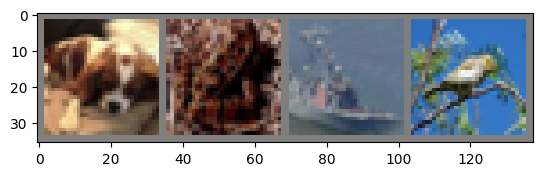

dog   frog  ship  bird 


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Define a Convolutional NN

Like the one in the [nn tutorial](3_nn.ipynb) but modified to take 3-channel images (instead of 1-channel images as it was defined).

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

# Define Loss Function and Optimizer

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Training the network

Loop over our data iterator, and feed the inputs to the network and optimize.

In [6]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

# aroud 14sec per 2000 mini-batches on my laptop CPU -> 2m29s for 2 epochs

[1,  2000] loss: 2.249
[1,  4000] loss: 1.930
[1,  6000] loss: 1.711
[1,  8000] loss: 1.604
[1, 10000] loss: 1.551
[1, 12000] loss: 1.494
[2,  2000] loss: 1.409
[2,  4000] loss: 1.355
[2,  6000] loss: 1.338
[2,  8000] loss: 1.318
[2, 10000] loss: 1.279
[2, 12000] loss: 1.281
Finished Training


In [7]:
# save trained model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

# Test the network on the test data

We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

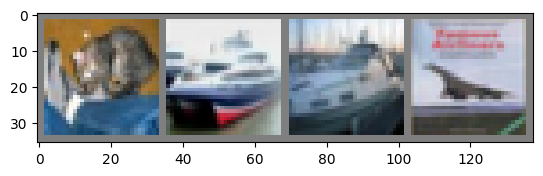

GroundTruth:  cat   ship  ship  plane


In [8]:
# Let us display an image from the test set to get familiar.

dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


In [9]:
# Next, let’s load back in our saved model (note: saving and re-loading the
# model wasn’t necessary here, we only did it to illustrate how to do so):

net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

Let us see what the neural network thinks these examples above are:

In [10]:
outputs = net(images)

# The outputs are energies for the 10 classes. The higher the energy for a
# class, the more the network thinks that the image is of the particular class.
# So, let’s get the index of the highest energy:

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  frog  ship  ship  ship 


Let us look at how the network performs on the whole dataset.

In [11]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

# 9 sec on my laptop CPU

Accuracy of the network on the 10000 test images: 54 %


That looks way better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

What are the classes that performed well, and the classes that did not perform well:

In [12]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

# 9 sec on my laptop CPU

Accuracy for class: plane is 61.2 %
Accuracy for class: car   is 77.1 %
Accuracy for class: bird  is 52.6 %
Accuracy for class: cat   is 12.9 %
Accuracy for class: deer  is 34.3 %
Accuracy for class: dog   is 52.6 %
Accuracy for class: frog  is 73.4 %
Accuracy for class: horse is 47.9 %
Accuracy for class: ship  is 69.6 %
Accuracy for class: truck is 67.4 %


# Training on GPU

Let’s first define our device as the first visible cuda device if we have CUDA available:

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


Then these methods will recursively go over all modules and convert their parameters and buffers to CUDA tensors:

```python
  net.to(device)
```
Remember  to send the inputs and targets at every step to the GPU too:
```python
  inputs, labels = data[0].to(device), data[1].to(device)
```

Let's try

In [17]:
# TRAINING

net.to(device)

for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}")
            running_loss = 0.0

print("Finished Training")

# TEST

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the 10000 test images: {100 * correct // total} %")


[1,  2000] loss: 1.207
[1,  4000] loss: 1.231
[1,  6000] loss: 1.203
[1,  8000] loss: 1.225
[1, 10000] loss: 1.217
[1, 12000] loss: 1.209
[2,  2000] loss: 1.203
[2,  4000] loss: 1.216
[2,  6000] loss: 1.213
[2,  8000] loss: 1.218
[2, 10000] loss: 1.222
[2, 12000] loss: 1.222
Finished Training
Accuracy of the network on the 10000 test images: 54 %


Why don’t I notice MASSIVE speedup compared to CPU? Because your network is really small.